In [16]:
import torch
import random
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('Model', 'PyTorch_CIFAR10'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from cifar10_models.resnet import resnet18

In [4]:
# weight distribution for all layers

import torch
import matplotlib.pyplot as plt

def analyze_model_weights(model, folder_name):
    weights = []
    
    for param in model.parameters():
        if param.requires_grad:  # 학습 가능한 가중치만 선택
            weights.append(param.data.view(-1))  # 1D 텐서로 변환
    
    weights = torch.cat(weights)  # 모든 가중치를 하나의 벡터로 결합
    
    abs_min = torch.min(torch.abs(weights)).item()
    abs_max = torch.max(torch.abs(weights)).item()
    
    # 0보다 큰 값 중 최소값 찾기
    positive_weights = weights[weights > 0]  # 0보다 큰 값 필터링
    min_positive = positive_weights.min().item() if positive_weights.numel() > 0 else None  # 값이 있을 때만 최소값 계산
    
    # 0보다 작은 값 중 최소값 찾기
    negative_weights = weights[weights < 0]  
    min_negative = negative_weights.max().item() if negative_weights.numel() > 0 else None  # 값이 있을 때만 최소값 계산


    print(f"Absolute Min: {abs_min}, Absolute Max: {abs_max:.5f}")
    print(f"Min Positive Value: {min_positive}, Min Negative Value: {min_negative}")
    
    # 가중치 분포 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1행 2열 서브플롯
    
    # 전체 제목 (중앙)
    fig.suptitle(folder_name, fontsize=16, fontweight='bold')  

    # Linear scale subplot
    axes[0].hist(weights.cpu().numpy(), bins=200, alpha=0.75, color='blue')
    axes[0].set_xlabel("Weight Values")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Weight Distribution (Linear Scale)")
    axes[0].grid(True)

    # Log scale subplot
    axes[1].hist(weights.cpu().numpy(), bins=200, alpha=0.75, color='blue')
    axes[1].set_xlabel("Weight Values")
    axes[1].set_ylabel("Frequency (log scale)")
    axes[1].set_title("Weight Distribution (Log Scale)")
    axes[1].set_yscale('log')  # 로그 스케일 적용
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return abs_min, abs_max

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from network import InfModel

# cnn / fc legend
def extract_weights(model):
    conv_weights = []
    fc_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name and len(param.size()) > 1:  # Consider only convolutional and fully connected layers
            if len(param.size()) == 4:  # Convolutional layers
                conv_weights.append(param.data.cpu().numpy().flatten())
            elif len(param.size()) == 2:  # Fully connected layers
                fc_weights.append(param.data.cpu().numpy().flatten())
    return conv_weights, fc_weights


def plot_weights(model, model_name):
    conv_weights, fc_weights = extract_weights(model)
    
     # Flatten the weights list
    all_conv_weights = np.concatenate(conv_weights) if conv_weights else np.array([])
    all_fc_weights = np.concatenate(fc_weights) if fc_weights else np.array([])

    # 0보다 큰 값 중 최소값 찾기
    positive_weights = all_conv_weights[all_conv_weights > 0]  # NumPy 배열에서 필터링
    min_posi = positive_weights.min() if positive_weights.size > 0 else None  # 값이 있을 때만 최소값 계산
    
    # 0보다 작은 값 중 최대값 찾기
    negative_weights = all_conv_weights[all_conv_weights < 0]
    min_nega = negative_weights.max() if negative_weights.size > 0 else None  # 값이 있을 때만 최대값 계산


    print(f"Min Positive Value: {min_posi}, Min Negative Value: {min_nega}")
    
    # Plot the distribution of weights
    plt.hist(all_conv_weights, bins=100, alpha=0.7, label="conv")
    plt.hist(all_fc_weights, bins=100, alpha=0.7, label="fc")
    plt.title(f'{model_name}')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, axis='y')
    plt.yscale('log')
    plt.show()

def plot_norm_weights(model, model_name):
    conv_weights, fc_weights = extract_weights(model)
    
    # 각 레이어별 min-max 정규화: 각 레이어의 최소값을 -1, 최대값을 1로 매핑
    norm_conv_weights = []
    for layer in conv_weights:
        layer_min = np.min(layer)
        layer_max = np.max(layer)
        if layer_max > layer_min:
            # (x - min) / (max - min) 를 통해 [0, 1]로 변환 후, 2배하고 -1 하면 [-1, 1] 범위가 됨.
            norm_layer = 2 * ((layer - layer_min) / (layer_max - layer_min)) - 1
        else:
            # 만약 layer가 상수값이면 0으로 설정
            norm_layer = np.zeros_like(layer)
        norm_conv_weights.append(norm_layer)
    
    norm_fc_weights = []
    for layer in fc_weights:
        layer_min = np.min(layer)
        layer_max = np.max(layer)
        if layer_max > layer_min:
            norm_layer = 2 * ((layer - layer_min) / (layer_max - layer_min)) - 1
        else:
            norm_layer = np.zeros_like(layer)
        norm_fc_weights.append(norm_layer)
    
    # 정규화된 weight들을 하나의 벡터로 결합
    all_norm_conv_weights = np.concatenate(norm_conv_weights) if norm_conv_weights else np.array([])
    all_norm_fc_weights = np.concatenate(norm_fc_weights) if norm_fc_weights else np.array([])
    
    # 예시: 정규화된 값들에서 0보다 큰 값 중 최소값, 0보다 작은 값 중 최대값도 확인 (conv layer 기준)
    positive_weights = all_norm_conv_weights[all_norm_conv_weights > 0]
    min_posi = positive_weights.min() if positive_weights.size > 0 else None
    
    negative_weights = all_norm_conv_weights[all_norm_conv_weights < 0]
    max_nega = negative_weights.max() if negative_weights.size > 0 else None
    
    print(f"Min Positive (Normalized) Value: {min_posi}, Max Negative (Normalized) Value: {max_nega}")
    
    # 정규화된 weight 분포 시각화 (히스토그램)
    plt.hist(all_norm_conv_weights, bins=100, alpha=0.7, label="Normalized Conv")
    plt.hist(all_norm_fc_weights, bins=100, alpha=0.7, label="Normalized FC")
    plt.title(f'{model_name} (Normalized Weights)')
    plt.xlabel('Normalized Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, axis='y')
    plt.yscale('log')  # 로그 스케일 적용
    plt.show()
    
# Conductance 변환 함수
def convert_weights_to_conductance(model, rpu_config):
    conductance_list = []
    min_gp, min_gm = None, None  # initialization

    for name, param in model.named_parameters():
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()
            
            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환

            conductance_list.append((gp.flatten(), gm.flatten()))
            
            # 0이 아닌 값들만 필터링
            gp_nonzero = gp[gp > 0]  # 0보다 큰 값만 선택
            gm_nonzero = gm[gm > 0]  # 0보다 큰 값만 선택

            # 최소값 업데이트 (값이 존재할 때만)
            if gp_nonzero.numel() > 0:
                min_gp = gp_nonzero.min().item() if min_gp is None else min(min_gp, gp_nonzero.min().item())
            if gm_nonzero.numel() > 0:
                min_gm = gm_nonzero.min().item() if min_gm is None else min(min_gm, gm_nonzero.min().item())

    print(f"Min Nonzero Gp: {min_gp}, Min Nonzero Gm: {min_gm}")

    return conductance_list

# Conductance distribution plot
def plot_conductance_distribution(model, model_name):
    
    inf_model = InfModel(model, "cifar10")
    rpu_config = inf_model.SetConfig()
    analog_model = inf_model.ConvertModel()
    
    conductance_list = convert_weights_to_conductance(analog_model, rpu_config)
    
    gp_all = np.concatenate([gp for gp, _ in conductance_list]) if conductance_list else np.array([])
    gm_all = np.concatenate([gm for _, gm in conductance_list]) if conductance_list else np.array([])

    plt.hist(gp_all, bins=100, alpha=1, label="Gp (positive conductance)")
    plt.hist(gm_all, bins=100, alpha=0.7, label="Gm (negative conductance)")
    plt.title(f'Conductance Distribution: {model_name}')
    plt.xlabel('Conductance value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, axis='y')
    plt.yscale('log')
    plt.show()
    
    

In [94]:
# revision code for plotting-g-dist.

import numpy as np
import matplotlib.pyplot as plt

# Conductance 변환 함수 (FC / Conv 분리)
def convert_weights_to_conductance(model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    min_gp_fc, min_gm_fc = None, None
    min_gp_conv, min_gm_conv = None, None

    for name, param in model.named_parameters():
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()
            
            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환

            # 0이 아닌 값들만 필터링
            gp_nonzero = gp[gp > 0]  # 0보다 큰 값만 선택
            gm_nonzero = gm[gm > 0]  # 0보다 큰 값만 선택

            if "fc" in name or weights.shape[0] <= 10:  # Fully Connected Layer
                conductance_list_fc.append((gp.flatten(), gm.flatten()))

                # 최소값 업데이트
                if gp_nonzero.numel() > 0:
                    min_gp_fc = gp_nonzero.min().item() if min_gp_fc is None else min(min_gp_fc, gp_nonzero.min().item())
                if gm_nonzero.numel() > 0:
                    min_gm_fc = gm_nonzero.min().item() if min_gm_fc is None else min(min_gm_fc, gm_nonzero.min().item())

            else:  # Convolutional Layer
                conductance_list_conv.append((gp.flatten(), gm.flatten()))

                # 최소값 업데이트
                if gp_nonzero.numel() > 0:
                    min_gp_conv = gp_nonzero.min().item() if min_gp_conv is None else min(min_gp_conv, gp_nonzero.min().item())
                if gm_nonzero.numel() > 0:
                    min_gm_conv = gm_nonzero.min().item() if min_gm_conv is None else min(min_gm_conv, gm_nonzero.min().item())

    print(f"Min Nonzero Gp (FC): {min_gp_fc}, Min Nonzero Gm (FC): {min_gm_fc}")
    print(f"Min Nonzero Gp (Conv): {min_gp_conv}, Min Nonzero Gm (Conv): {min_gm_conv}")

    return conductance_list_fc, conductance_list_conv

# Conductance distribution plot (subplot 사용)
def plot_conductance_distribution(model, model_name):
    inf_model = InfModel(model, "cifar10")
    rpu_config = inf_model.SetConfig()
    analog_model = inf_model.ConvertModel()

    conductance_list_fc, conductance_list_conv = convert_weights_to_conductance(analog_model, rpu_config)

    gp_fc_all = np.concatenate([gp for gp, _ in conductance_list_fc]) if conductance_list_fc else np.array([])
    gm_fc_all = np.concatenate([gm for _, gm in conductance_list_fc]) if conductance_list_fc else np.array([])

    gp_conv_all = np.concatenate([gp for gp, _ in conductance_list_conv]) if conductance_list_conv else np.array([])
    gm_conv_all = np.concatenate([gm for _, gm in conductance_list_conv]) if conductance_list_conv else np.array([])

    fig, axes = plt.subplots(1,2, figsize=(12, 5))
    # 전체 제목 (중앙)
    fig.suptitle(model_name, fontsize=14, fontweight='bold')  

    # FC 레이어 Conductance Plot
    axes[0].hist(gp_fc_all, bins=150, alpha=1, label="Gp (FC)")
    axes[0].hist(-gm_fc_all, bins=150, alpha=0.7, label="Gm (FC)")
    axes[0].set_title('G Distribution (FC)')
    axes[0].set_xlabel('Conductance Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, axis='y')
    axes[0].set_yscale('log')

    # Conv 레이어 Conductance Plot
    axes[1].hist(gp_conv_all, bins=500, alpha=1, label="Gp (Conv)")
    axes[1].hist(-gm_conv_all, bins=500, alpha=0.7, label="Gm (Conv)")
    axes[1].set_title('G Distribution (Conv)')
    axes[1].set_xlabel('Conductance Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, axis='y')
    axes[1].set_yscale('log')
    # axes[1].set_xlim(-0.1,10)

    plt.tight_layout()
    plt.show()

Min Nonzero Gp (FC): 1.5533875226974487, Min Nonzero Gm (FC): 1.5251882076263428
Min Nonzero Gp (Conv): 0.13987313210964203, Min Nonzero Gm (Conv): 0.139871746301651


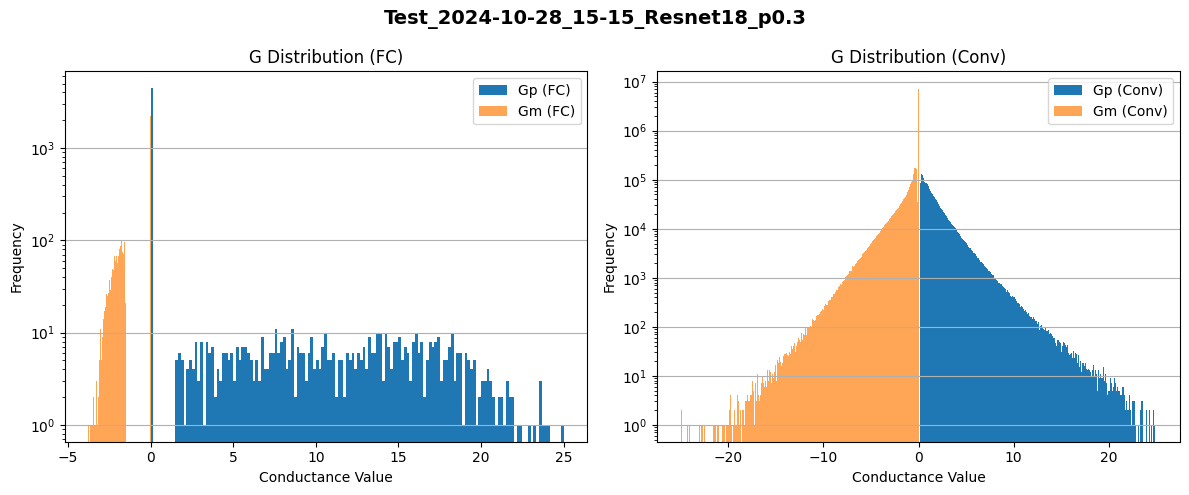

In [95]:
folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
model = torch.load(f'{folder_path}/{model_name}')

plot_conductance_distribution(model, folder_name)  # conductance distribution

Min Nonzero Gp (FC): 1.7094758749008179, Min Nonzero Gm (FC): 1.6942847967147827
Min Nonzero Gp (Conv): 0.1901388019323349, Min Nonzero Gm (Conv): 0.19013768434524536


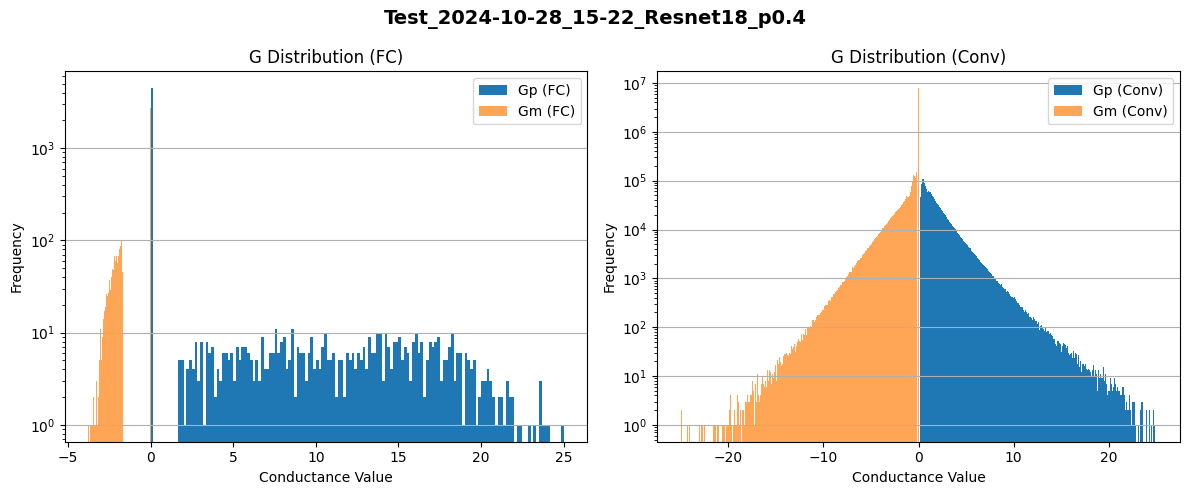

In [96]:
folder_name = 'Test_2024-10-28_15-22_Resnet18_p0.4'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
model = torch.load(f'{folder_path}/{model_name}')

plot_conductance_distribution(model, folder_name)  # conductance distributio

Min Nonzero Gp (FC): 1.8831217288970947, Min Nonzero Gm (FC): 1.8464552164077759
Min Nonzero Gp (Conv): 0.2487807273864746, Min Nonzero Gm (Conv): 0.24877698719501495


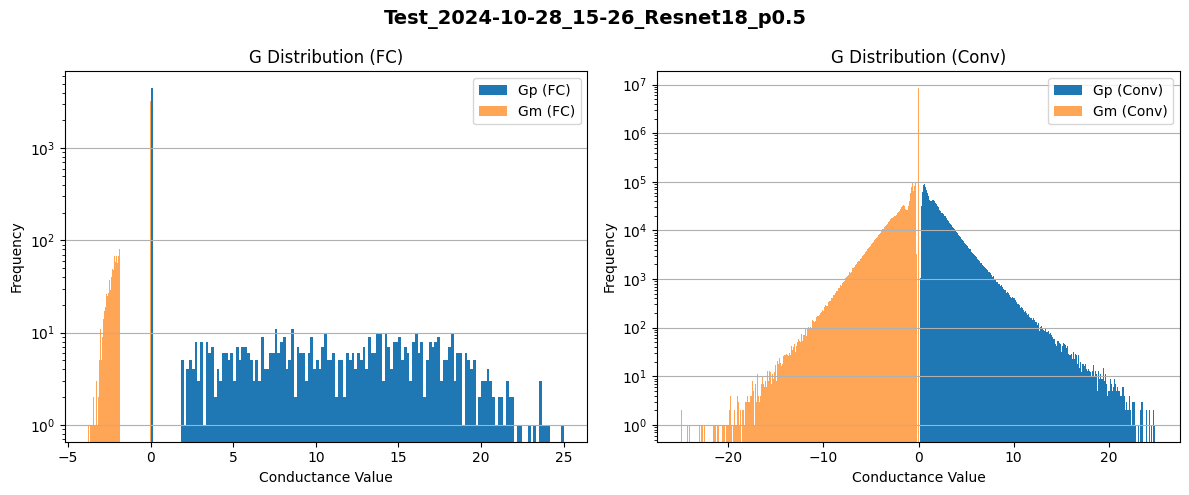

In [97]:
folder_name = 'Test_2024-10-28_15-26_Resnet18_p0.5'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
model = torch.load(f'{folder_path}/{model_name}')

plot_conductance_distribution(model, folder_name)  # conductance distribution

Min Nonzero Gp (FC): 2.1510400772094727, Min Nonzero Gm (FC): 2.0187833309173584
Min Nonzero Gp (Conv): 0.32822760939598083, Min Nonzero Gm (Conv): 0.32822921872138977


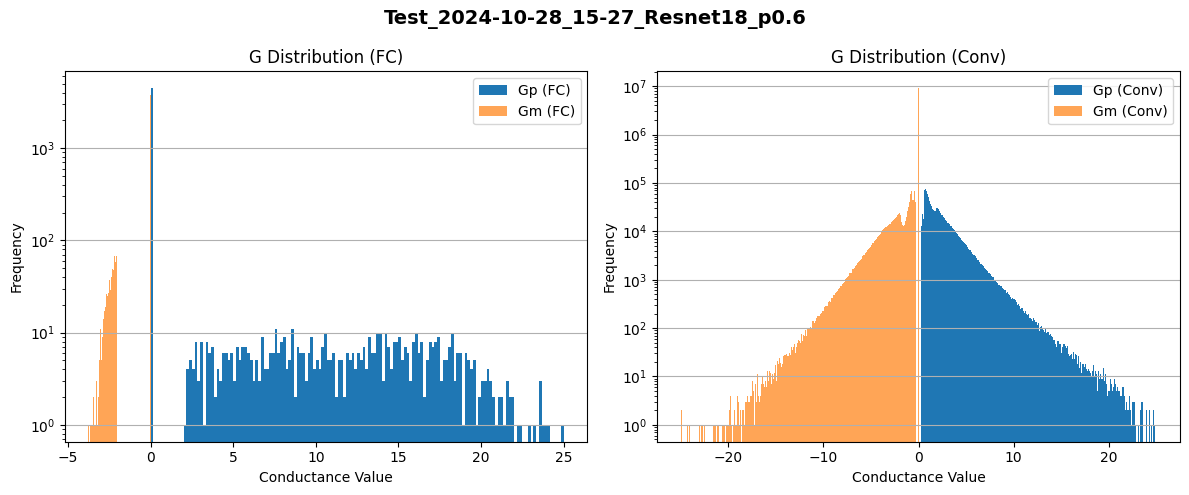

In [98]:
folder_name = 'Test_2024-10-28_15-27_Resnet18_p0.6'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
model = torch.load(f'{folder_path}/{model_name}')

plot_conductance_distribution(model, folder_name)  # conductance distribution

Min Positive (Normalized) Value: 1.1920928955078125e-07, Max Negative (Normalized) Value: -2.980232238769531e-07


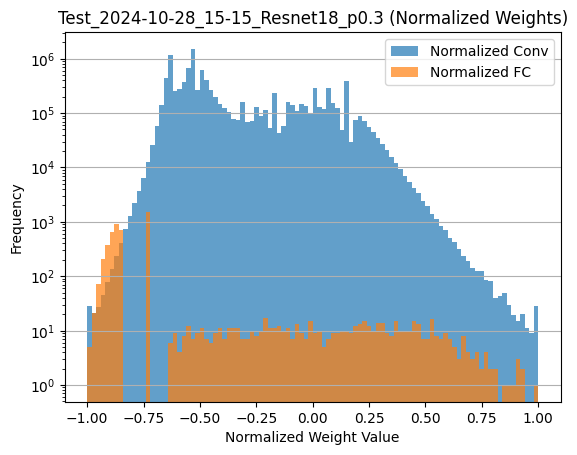

In [ ]:
# weight distribution - normalize btw [-1, 1] 

import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_norm_weights(model, folder_name)

In [20]:
conv_weights, fc_weights = extract_weights(model)

In [21]:
conv_weights

[array([ 0.02321908,  0.05806632,  0.03181854, ..., -0.00739009,
         0.00725325,  0.        ], dtype=float32),
 array([ 0.00628015,  0.00514479, -0.00117541, ...,  0.00306997,
         0.00651648,  0.00350876], dtype=float32),
 array([ 0.00287212,  0.        ,  0.        , ..., -0.00799529,
         0.        , -0.        ], dtype=float32),
 array([ 0.00735277,  0.00426802,  0.00229479, ..., -0.00357516,
         0.00359326, -0.        ], dtype=float32),
 array([ 0.00634524,  0.00966469, -0.        , ..., -0.0072438 ,
        -0.00614158,  0.00755578], dtype=float32),
 array([ 0.00440122,  0.0070317 ,  0.        , ...,  0.00312522,
        -0.00239964, -0.        ], dtype=float32),
 array([-0.01023024,  0.        , -0.00223521, ..., -0.00295239,
         0.00257678,  0.00269075], dtype=float32),
 array([ 0.02209109, -0.01284246, -0.        , ...,  0.01709459,
        -0.02380284,  0.        ], dtype=float32),
 array([ 0.00916918, -0.00281484, -0.00799076, ...,  0.00460099,
       

Min Positive Value: 4.362919935374521e-05, Min Negative Value: -4.362919935374521e-05


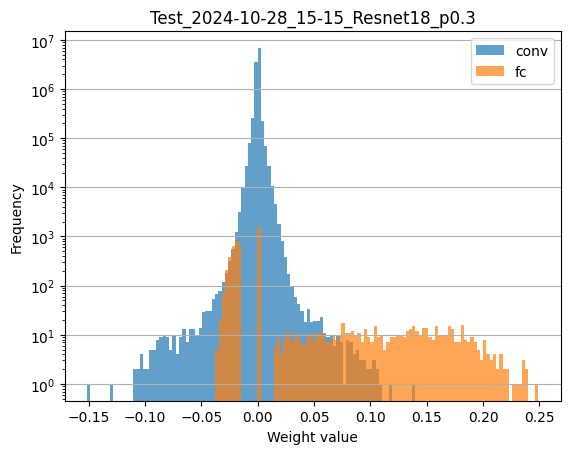

In [11]:
import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name)

Min Positive Value: 6.0688937082886696e-05, Min Negative Value: -6.0688998928526416e-05


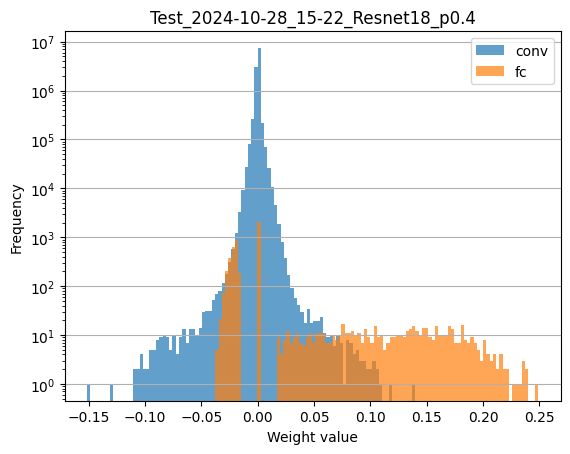

In [12]:
folder_name = 'Test_2024-10-28_15-22_Resnet18_p0.4'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name) 

Min Positive Value: 8.043241541599855e-05, Min Negative Value: -8.043296838877723e-05


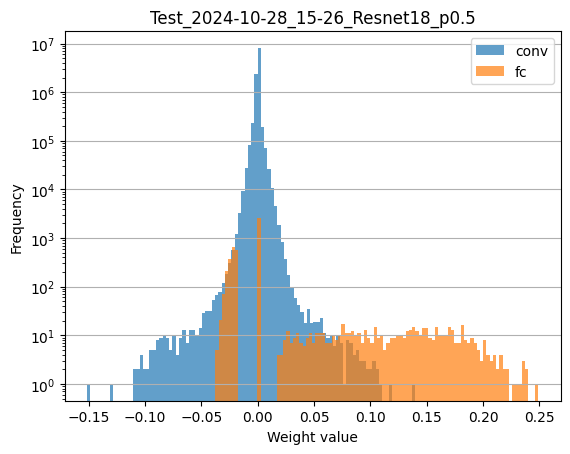

In [13]:
folder_name = 'Test_2024-10-28_15-26_Resnet18_p0.5'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name) 

Min Positive Value: 0.0001375446154270321, Min Negative Value: -0.00013754489191342145


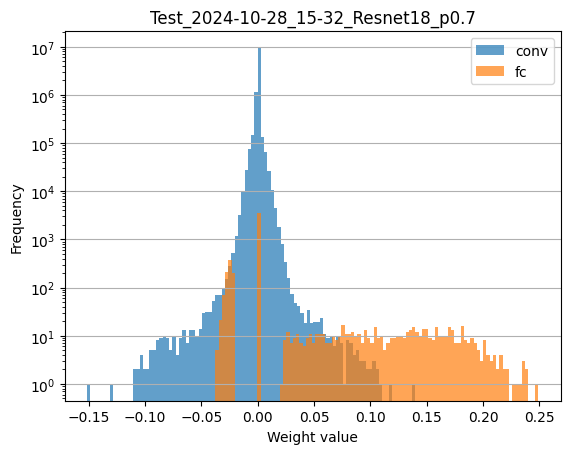

In [15]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name) 

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


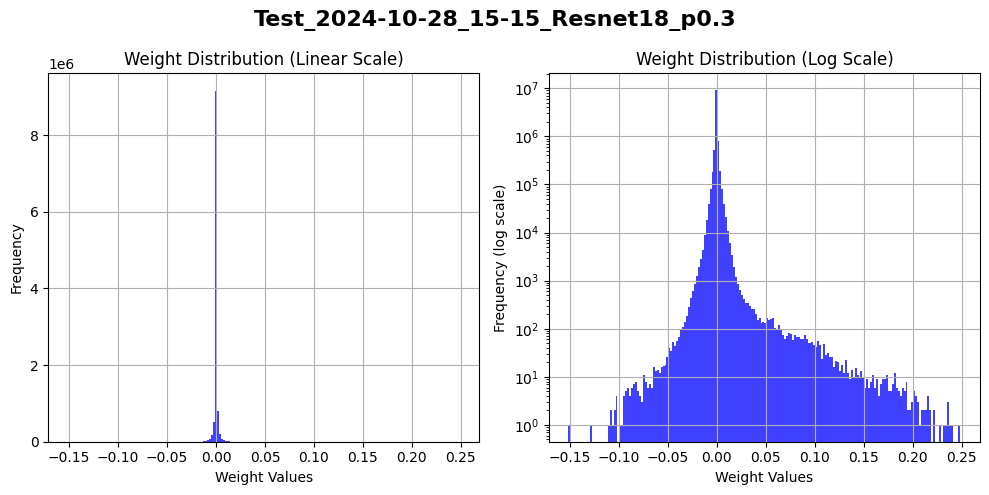

(0.0, 0.2488204836845398)

In [5]:
import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


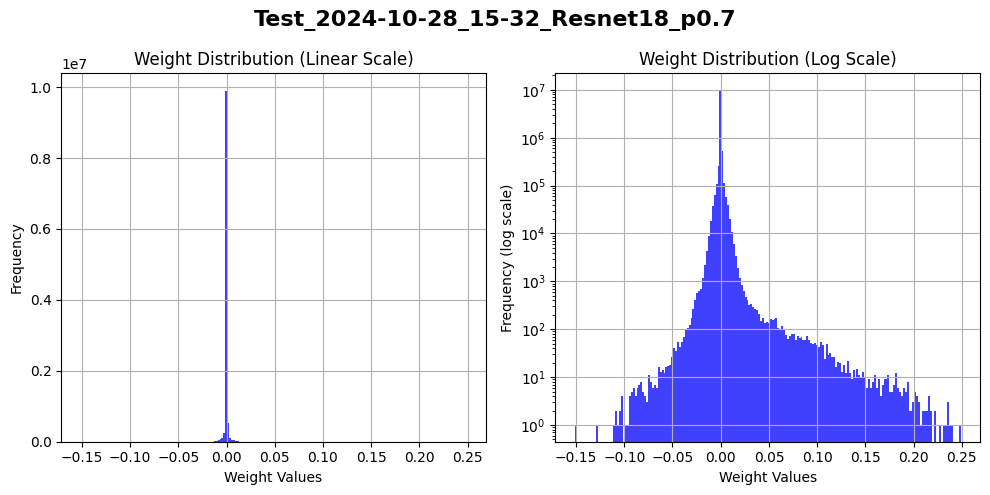

(0.0, 0.2488204836845398)

In [30]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from network import InfModel
import os
import torch

# Conductance 변환 함수 (레이어별로 min Gp, Gm 저장)
def convert_weights_to_conductance_layerwise(model, rpu_config):
    conductance_dict = {}  # Layer별 Min Nonzero Gp, Gm 저장

    for name, param in model.named_parameters():
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()

            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # (Gp, Gm)

            # 0이 아닌 값들만 필터링
            gp_nonzero = gp[gp > 0]  
            gm_nonzero = gm[gm > 0]  

            # Nonzero min 찾기 (값이 없으면 None 처리)
            min_gp = gp_nonzero.min().item() if gp_nonzero.numel() > 0 else None
            min_gm = gm_nonzero.min().item() if gm_nonzero.numel() > 0 else None

            # 레이어별로 저장
            conductance_dict[name] = {"Min Nonzero Gp": min_gp, "Min Nonzero Gm": min_gm}

    return conductance_dict

# 🚀 ResNet18에 적용
def analyze_resnet18_conductance(model, model_name):
    inf_model = InfModel(model, "cifar10")
    rpu_config = inf_model.SetConfig()
    analog_model = inf_model.ConvertModel()

    # Conductance 변환 및 레이어별 최소값 저장
    conductance_dict = convert_weights_to_conductance_layerwise(analog_model, rpu_config)

    # 📌 출력: 레이어별 Min Nonzero Gp, Gm 정리
    print(f"\n=== {model_name} - Layer-wise Min Nonzero Conductance ===")
    for layer, values in conductance_dict.items():
        print(f"{layer} \t\t\t → Gp Min: {values['Min Nonzero Gp']:.6f}, Gm Min: {values['Min Nonzero Gm']:.6f}")



In [14]:
import os
import torch

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_resnet18_conductance(model, folder_name)


=== Test_2024-10-28_15-15_Resnet18_p0.3 - Layer-wise Min Nonzero Conductance ===
conv1.analog_module.shared_weights 			 → Gp Min: 0.865173, Gm Min: 0.863134
layer1.0.conv1.analog_module.shared_weights 			 → Gp Min: 0.397282, Gm Min: 0.397248
layer1.0.conv2.analog_module.shared_weights 			 → Gp Min: 1.454223, Gm Min: 1.453483
layer1.1.conv1.analog_module.shared_weights 			 → Gp Min: 1.295248, Gm Min: 1.294663
layer1.1.conv2.analog_module.shared_weights 			 → Gp Min: 1.115811, Gm Min: 1.115764
layer2.0.conv1.analog_module.shared_weights 			 → Gp Min: 1.561460, Gm Min: 1.561696
layer2.0.conv2.analog_module.shared_weights 			 → Gp Min: 1.398355, Gm Min: 1.398339
layer2.0.downsample.0.analog_module.shared_weights 			 → Gp Min: 1.138983, Gm Min: 1.138577
layer2.1.conv1.analog_module.shared_weights 			 → Gp Min: 1.560257, Gm Min: 1.560094
layer2.1.conv2.analog_module.shared_weights 			 → Gp Min: 1.098450, Gm Min: 1.098585
layer3.0.conv1.analog_module.shared_weights 			 → Gp Min: 0.904171, Gm